In [45]:
import networkx as nx
import pprint
import random
import matplotlib.pyplot as plt
import numpy as np

In [46]:
def generate_exchange_matrix(size: int, graph: nx.Graph) -> list:
    """Create an exchange matrix representing communication costs between nodes.

    Args:
        size (int): Size of the matrix (size x size).
        graph (nx.Graph): Network topology graph.

    Returns:
        list: Square matrix of size n x n.
    """
    adj_list = nx.to_dict_of_lists(graph)
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i == j:
                matrix[i][j] = 0
            elif j in adj_list[i]:
                matrix[i][j] = random.randint(1, 100)
            else:
                matrix[i][j] = -1

    for i in range(size):
        for j in range(size):
            if j in adj_list[i]:
                graph.add_edge(i, j, weight=matrix[i][j])

    return matrix

In [47]:
def generate_random_graph(num_nodes: int) -> nx.Graph:
    """Create a graph representing the network topology.

    Args:
        num_nodes (int): Number of nodes in the graph.

    Returns:
        nx.Graph: Graph representing the topology.
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i in range(num_nodes):
        G.add_edge(i, (i + 1) % num_nodes)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < 0.5:
                G.add_edge(i, j)

    return G


In [48]:
def weightintg_graph(graph: nx.Graph, exchange_matrix: list):
    """Assign weights (communication costs) to the graph edges.

    Args:
        graph (nx.Graph): Weighted graph representing the topology.
        exchange_matrix (list): Exchange matrix representing the communication costs.
    """
    num_nodes = len(exchange_matrix)
    adj_list = nx.to_dict_of_lists(graph)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if j in adj_list[i]:
                graph.add_edge(i, j, weight=exchange_matrix[i][j])

In [49]:
def create_block_matrix(num_rows: int, num_cols: int) -> list:
    """ニューラルネットワークを分割したブロックの接続関係を表す行列を作成

    Args:
        num_rows (int): 分割ブロックの行数
        num_cols (int): 分割ブロックの列数

    Returns:
        list: ブロック間の接続を表す行列
        
    Example:
        num_rows = 2, num_cols = 3の場合
        -----
        1 3 5
        2 4 6
        -----
        
        となり接続関係は以下のようになる
        接続関係を持っていれば1, なければ0
        --------------------
        [[0, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1],
        [0, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 0]]
        --------------------
    """
    matrix_size = num_rows * num_cols
    matrix = [[0] * matrix_size for _ in range(matrix_size)]

    # Helper function to check if a block is within the matrix bounds
    def is_valid_block(row, col):
        return 0 <= row < num_rows and 0 <= col < num_cols

    # Iterate over each block in depth-first order
    for block in range(matrix_size):
        col = block // num_rows
        row = block % num_rows

        # Connect to vertical neighbors
        if is_valid_block(row - 1, col):
            neighbor = (col * num_rows) + (row - 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row + 1, col):
            neighbor = (col * num_rows) + (row + 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to horizontal neighbors
        if is_valid_block(row, col - 1):
            neighbor = ((col - 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row, col + 1):
            neighbor = ((col + 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to diagonal neighbors
        if is_valid_block(row - 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row - 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1

    return matrix


In [50]:
def generate_block_list(num_blocks: int) -> list:
    """分割したブロックの番号リスト

    Args:
        num_nodes (int): 分割ブロックの数

    Returns:
        list: ブロックの番号リスト
        
    Example:
        num_blocks = 6の場合
        ------------------
        [0, 1, 2, 3, 4, 5]
        ------------------
    """    
    block_list = []
    for i in range(num_blocks):
        block_list.append(i)
    return block_list

In [51]:
def generate_assignment_block_list(num_pcs: int, num_blocks: int) -> list:
    """計算機が担当するブロックを表す行列

    Args:
        num_pcs (int): 計算機の数
        num_blocks (int): ブロックの数

    Returns:
        list: 計算機が担当するブラックを表す行列
        
    Example:
        num_pcs = 4, num_blocks = 6の場合
        [[1, 0, 0, 0, 1, 0],
         [0, 1, 0, 0, 0, 1],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0]]
        
        PC1 -> 0, 4のブロックを担当
        PC2 -> 1, 5のブロックを担当
        PC3 -> 2のブロックを担当
        PC4 -> 3のブロックを担当
    """    
    matrix = [[0] * num_blocks for _ in range(num_pcs)]

    # Distribute tasks to computers
    for task in range(num_blocks):
        computer = task % num_pcs
        matrix[computer][task] = 1

    return matrix

In [52]:
def get_task_assigned_pc(block_labe: int, assigned_matrix: list) -> int:
    """ブロックのラベルから担当する計算機の番号を返す

    Args:
        block_labe (int): ブロックのラベル
        task_matrix (list): 計算機が担当するブロックを表す行列

    Returns:
        int: 計算機の番号
    """
    pc_num = len(assigned_matrix)
    for pc in range(pc_num):
        if assigned_matrix[pc][block_labe] == 1:
            return pc
    

In [53]:
def get_linked_blocks(block_labe: int, block_linked_matrix: list) -> list:
    """ブロックのラベルから接続しているブロックのラベルのリストを返す

    Args:
        block_labe (int): ブロックのラベル
        matrix (list): 接続関係を持つ行列

    Returns:
        list: 接続しているブロックのラベルのリスト
    """
    linked_blocks = []
    for i in range(len(block_linked_matrix)):
        if block_linked_matrix[block_labe][i] == 1:
            linked_blocks.append(i)
    return linked_blocks

In [54]:
def get_communication_cost(starting_point_pc: int, graph: nx.graph, linked_blocks) -> int:
    """始点の計算機から各計算機への通信コストを取得する

    Args:
        starting_point_pc (int): 始点の計算機の番号
        exchange_matrix (list): 通信コストを表す行列

    Returns:
        int: _description_
    """
    cost = 0
    for target in linked_blocks:
        cost += nx.dijkstra_path_length(graph, starting_point_pc, target)
    return cost

交流行列
[[ 0. 93. -1. 28.]
 [73.  0.  1. 55.]
 [-1. 54.  0. 51.]
 [67. 16. 79.  0.]]

ニューラルネットワークの分割ブロックの接続関係を表す行列
[[0, 1, 1, 1, 0, 0],
 [1, 0, 1, 1, 0, 0],
 [1, 1, 0, 1, 1, 1],
 [1, 1, 1, 0, 1, 1],
 [0, 0, 1, 1, 0, 1],
 [0, 0, 1, 1, 1, 0]]

分割ブロックの番号リスト
[0, 1, 2, 3, 4, 5]

PCが担当するブロックの割り当て行列
[1, 0, 0, 0, 1, 0]
[0, 1, 0, 0, 0, 1]
[0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]

ブロック0を担当するPCの番号: 0
ブロック0に接続しているブロックの番号リスト: [1, 2, 3]
通信対象の計算機リスト: [1, 2, 3]
ブロック0を担当するPCからブロック0に接続しているブロックへの通信コスト: 267.0


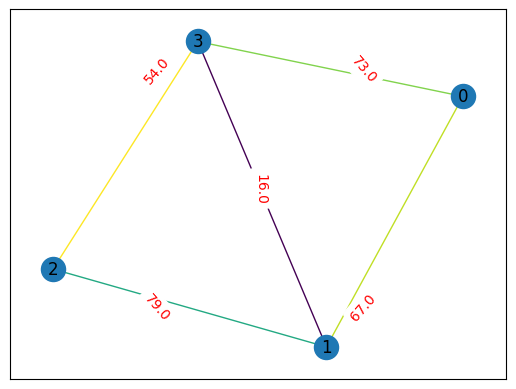

In [55]:
# ネットワークトポロジーを作成
G = generate_random_graph(4)

# 交流行列を作成
exchange_matrix = generate_exchange_matrix(4, G)

# グラフのエッジに通信コスト(交流行列より)を付与
weightintg_graph(G, exchange_matrix)

# グラフの描画
pos = nx.circular_layout(G)
weights = nx.get_edge_attributes(G, 'weight').values()
nx.draw_networkx(G, edge_color = weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

print("交流行列")
print(exchange_matrix)

block_linked_matrix = create_block_matrix(2, 3)
print("\nニューラルネットワークの分割ブロックの接続関係を表す行列")
pprint.pprint(block_linked_matrix)

block_list = generate_block_list(6)
print("\n分割ブロックの番号リスト")
print(block_list)

# Distribute tasks to computers
assigned_matrix = generate_assignment_block_list(4, 6)

print("\nPCが担当するブロックの割り当て行列")
# Print the task matrix
for row in assigned_matrix:
    print(row)
    

pc = get_task_assigned_pc(0, assigned_matrix)
print(f'\nブロック0を担当するPCの番号: {pc}')
linked_blocks = get_linked_blocks(0, block_linked_matrix)
print(f'ブロック0に接続しているブロックの番号リスト: {linked_blocks}')

# 通信する必要のあるPCを取得
targets = []
for i in linked_blocks:
    target = get_task_assigned_pc(i, assigned_matrix)
    targets.append(target)
print(f'通信対象の計算機リスト: {targets}')

cost = get_communication_cost(pc, G, linked_blocks)
print(f'ブロック0を担当するPCからブロック0に接続しているブロックへの通信コスト: {cost}')